# Mnist one sample per class active learning

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import semisup

from tensorflow.python.platform import app
from tensorflow.python.platform import flags

FLAGS = flags.FLAGS

flags.DEFINE_integer('sup_per_class', 2,
                       'Number of labeled samples used per class.')

flags.DEFINE_integer('sup_seed', -1,
                   'Integer random seed used for labeled set selection.')

flags.DEFINE_integer('sup_per_batch', -1,  # -1: use all that we have
                   'Number of labeled samples per class per batch.')

flags.DEFINE_integer('unsup_batch_size', 30,
                   'Number of unlabeled samples per batch.')

flags.DEFINE_integer('eval_interval', 500,
                   'Number of steps between evaluations.')

flags.DEFINE_float('learning_rate', 1e-3, 'Initial learning rate.')

flags.DEFINE_float('decay_factor', 0.33, 'Learning rate decay factor.')

flags.DEFINE_float('decay_steps', 5000,
                 'Learning rate decay interval in steps.')

flags.DEFINE_float('visit_weight', 1, 'Weight for visit loss.')
flags.DEFINE_float('walker_weight', 1, 'Weight for walker loss.')
flags.DEFINE_float('logit_weight', 1, 'Weight for logit loss.')
flags.DEFINE_float('l1_weight', 0.001, 'Weight for embedding l1 regularization.')

flags.DEFINE_integer('max_steps', 4000, 'Number of training steps.')
flags.DEFINE_integer('warmup_steps', 3000, 'Number of warmup steps.')

flags.DEFINE_integer('num_active_samples', 50, 'Number of active samples to request in total.')
flags.DEFINE_integer('num_new_samples_per_run', 5, 'Number of active samples to request every run.')

flags.DEFINE_string('logdir', '/tmp/semisup_mnist', 'Training log path.')
flags.DEFINE_string('sample_method', 'propose_samples_pb_sampling', 'Method used to add new samples')

flags.DEFINE_bool('semisup', True, 'Add unsupervised samples')

flags.DEFINE_bool('restart', False, 'Restart from scratch after a new sample was added')

flags.DEFINE_float('dropout_keep_prob', 1, 'Keep Prop in dropout. Set to 1 to deactivate dropout')

print(FLAGS.learning_rate, FLAGS.__flags) # print all flags (useful when logging)

from tools import mnist as mnist_tools

NUM_LABELS = mnist_tools.NUM_LABELS
IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE

0.001 {'unsup_batch_size': 30, 'max_steps': 4000, 'learning_rate': 0.001, 'logit_weight': 1, 'logdir': '/tmp/semisup_mnist', 'num_active_samples': 50, 'sample_method': 'propose_samples_pb_sampling', 'sup_per_batch': -1, 'decay_factor': 0.33, 'sup_per_class': 2, 'semisup': True, 'eval_interval': 500, 'walker_weight': 1, 'num_new_samples_per_run': 5, 'warmup_steps': 3000, 'restart': False, 'visit_weight': 1, 'dropout_keep_prob': 1, 'sup_seed': -1, 'decay_steps': 5000, 'l1_weight': 0.001}


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from mnist_train_eval_active import init_graph

In [4]:
from mnist_train_eval_active import init_data

sup_by_label, train_images, train_labels, test_images, test_labels, seed = init_data()

Extracting /usr/stud/plapp/data/mnist//train-images-idx3-ubyte.gz
Extracting /usr/stud/plapp/data/mnist//train-labels-idx1-ubyte.gz
Extracting /usr/stud/plapp/data/mnist//t10k-images-idx3-ubyte.gz
Extracting /usr/stud/plapp/data/mnist//t10k-labels-idx1-ubyte.gz
Seed: 399


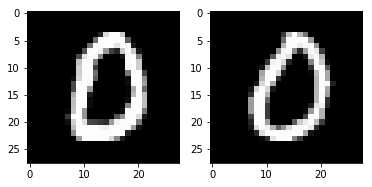

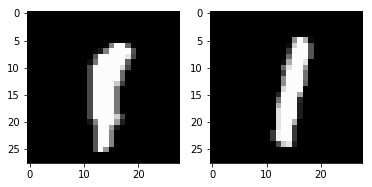

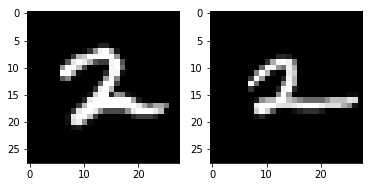

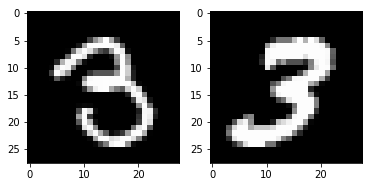

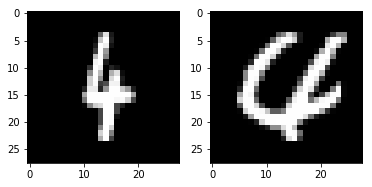

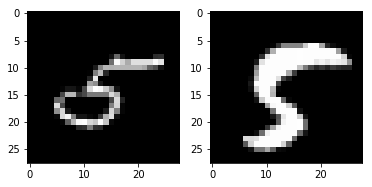

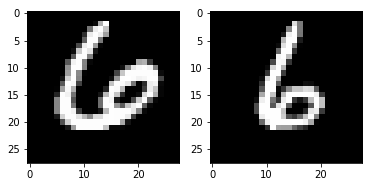

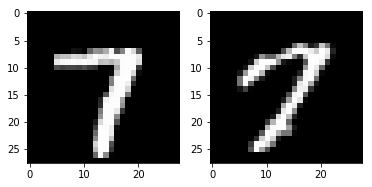

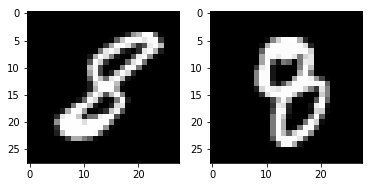

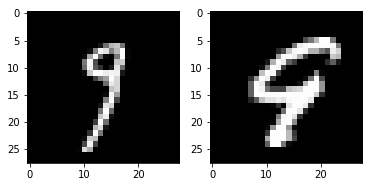

In [5]:
from backend import show_sample_img, show_sample_img_inline
for imgs in sup_by_label: 
    show_sample_img_inline(imgs) 

In [6]:
indices = []

logdir = FLAGS.logdir + '_' + str(seed) + '_' + str(len(indices))

In [7]:
unsup_batch_size = 30 # 30 for small count of sup samples, 100 for larger count
train_warmup, train_finetune, choose_sample, add_sample = \
    init_graph(sup_by_label, train_images, train_labels, test_images, test_labels, logdir, unsup_batch_size)

---------
Variables: name (type shape) [size]
---------
net/conv1_1/weights:0 (float32_ref 3x3x1x32) [288, bytes: 1152]
net/conv1_1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3_1/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3_1/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:0 (float32_ref 128) [128, bytes: 512]
net/fc1/weights:0 (float32_ref 1152x128) [147456, bytes: 589824]
net/fc1/biases:0 (float32_ref 128) [128, bytes: 512]
net/fully_connected/weights:0 (float32_ref 128x10) [1280, bytes: 5120]
net/fully_c

In [8]:
train_warmup()

Step: 99
[[130 108  65  43 209 185  45  92  14  89]
 [  1 334  23 101 478  34   3   4  76  81]
 [  4  81  52 398 253 142  35  11  15  41]
 [ 23  23  72 511 126  90  23  21  82  39]
 [ 53  45  21  20 306 332  37  12  34 122]
 [ 34  52  61 161 161 250  40  14  38  81]
 [ 27  73  87 137 157 389  67   0  18   3]
 [  7  24   8  82 217 131  23  63 238 235]
 [ 13  67  19 279 296 113   7  12 127  41]
 [ 10  33  21  77 273 368   4  19  90 114]]
Test error: 80.46 %
Train loss: 8.78 

Step: 499
[[625  13  23  19  29 161  37  48  14  11]
 [ 70 614  92  12   2  37  55   8  11 234]
 [ 47  15 111 279 247  36 185  48  57   7]
 [ 41  41  47 409  65  35 186 112  64  10]
 [ 56  29  50   4 432 170  92  56  21  72]
 [ 80  44  27  92  32 350 139 110  11   7]
 [ 37  71  50  24 176  74 508   2  11   5]
 [ 10  12  41  34  51  54  91 658  50  27]
 [ 46  70  38 148 138  92 205  70 143  24]
 [ 18  37  94  26 277 287  45 135  29  61]]
Test error: 60.89 %
Train loss: 5.01 

Step: 999
[[554   1  34  10  11 294  28  

total number of supervised samples (20,)
ths 3.2149805179e-06 1.04194723349e-06
class distribution for not confident samples [ 265  531  853 1514  617 1362  385 1206  939  728]
class distribution for not confident and "clustered" samples [  1   0   0 416   5 264   0  32  47  75]
sampled new images with labels [3 3 9 5 3]


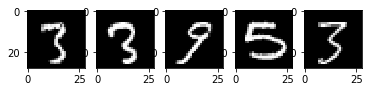

[3 3 9 5 3]


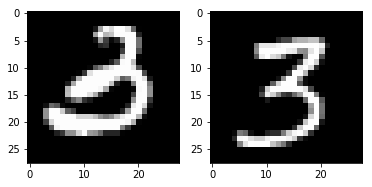

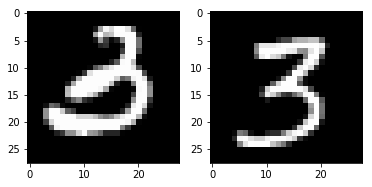

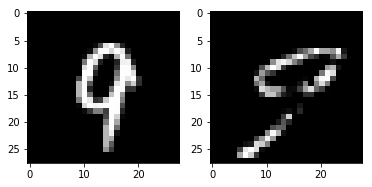

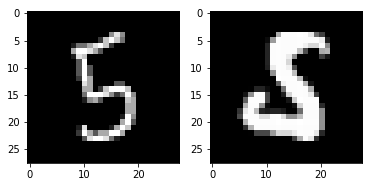

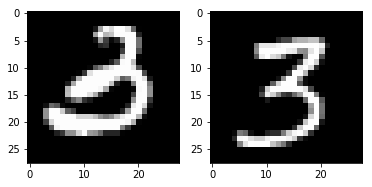

In [11]:
import numpy as np

#propose 5 samples
inds = choose_sample("propose_samples_pb_sampling") 
show_sample_img_inline(train_images[inds][0:5])

print(train_labels[inds])
chosen_inds = inds
#chosen_inds = inds[:3]
for ind in chosen_inds:
    show_sample_img_inline(sup_by_label[train_labels[ind]]) 

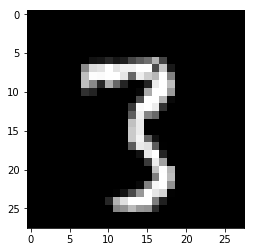

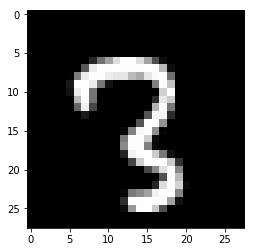

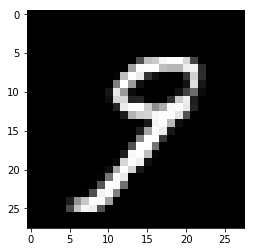

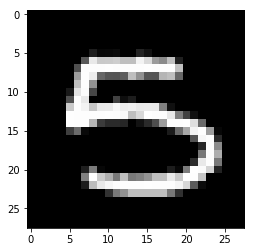

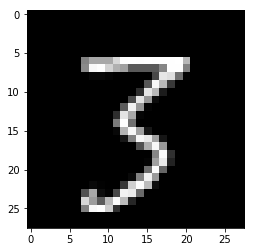

In [12]:
# add to training set
for ind in chosen_inds:
    indices.append(ind)
    add_sample(ind) 
    show_sample_img(train_images[ind])

### That was one iteration
Now, either re-initialize the graph (Cell 9) and start from scratch, 
or continue with this graph (either warmup or finetune)

In [15]:
# finetune. This is equal to standard mnist training (no warmup)
train_finetune(lr=0.001)

Step: 99
[[936   7   1   0   9   4   1   3   4  15]
 [  0 897   4   5 227   0   0   0   0   2]
 [  4  10 956   3   3   9   0  36   1  10]
 [  1   1  29 959   1   1   0   9   5   4]
 [  0  31   0   1  75 809   2   3   1  60]
 [  8  12   6 600   9  29 134   1  79  14]
 [ 25  40   1   0 172  19 690   0  10   1]
 [  0   2  46   2   2   3   0 817   1 155]
 [ 39  15  15   1  58  22   1  20 761  42]
 [  3   3   1  32  13  48   0  10   1 898]]
Test error: 29.82 %
Train loss: 5.16 

Step: 499
[[954   2   1   0   4   2   3   2   8   4]
 [  0 793   3   6 330   0   0   0   1   2]
 [  5   5 957   1   1   4   0  53   3   3]
 [  1   0   9 962   0   0   0  29   4   5]
 [  4  17   0   1  42 860   6   6   2  44]
 [ 12   3   2 510   8  62 159   3 115  18]
 [ 18  11   0   0 134  11 768   0  16   0]
 [  0   2  32   0   3   2   0 904   1  84]
 [ 32   8   4   1  35  16   9  38 822   9]
 [  6   1   0  21  12  74   1  40   5 849]]
Test error: 28.87 %
Train loss: 5.06 

Step: 999
[[963   2   1   0  10   0   1  

KeyboardInterrupt: 

In [ ]:
# finalize
train_warmup, train_finetune, choose_sample, add_sample = init_graph()

train_warmup()
train_finetune()
train_finetune(lr=0.0001)

print('chosen indices', indices)